# Setup

In [1]:
import pandas as pd
import os
from scipy.io import arff
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import StackingClassifier

# Loading the data

In [2]:
# Loading the data
def load_data(filepath):
    data,meta = arff.loadarff(filepath)
    my_df = pd.DataFrame(data)
    my_df = my_df.applymap(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)
    return my_df

def explore_data(my_df):
    print(my_df.head().T)
    print(my_df.describe())
    print(my_df.info())

# Data Cleaning

In [3]:
def cleaning(my_df):
    cleaned_df= my_df.drop_duplicates()
    return cleaned_df

# Visualizing the data

In [4]:
def plot_bar_chart(my_df):
    var_cat = my_df.select_dtypes(include=['object'])
    
    for column in var_cat.columns:
        plt.figure(figsize=(12, 6))
        ax = sns.countplot(data=my_df, x=column)
        
        plt.title(f'Distribution of {column}', fontsize=16)
        plt.xlabel(column, fontsize=14)
        plt.ylabel('Count', fontsize=14)
        plt.xticks(rotation=45, ha='right')
        
        for p in ax.patches:
            ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5), 
                    textcoords='offset points')

        warnings.filterwarnings('ignore', category=FutureWarning)
        ax.grid(True, linestyle='--', axis='y')

        plt.tight_layout()  
        plt.show()
        
def plot_heat_map(my_df):
    cat_encoder= LabelEncoder()
    lista_colmuns= [col for col in my_df.columns]
    
    for col in lista_colmuns:
        my_df[col]=cat_encoder.fit_transform(my_df[col])

    corr_matrix=my_df.corr()
    plt.figure(figsize=(10,10))
    plt.title(f'Relationship between Performance')
    sns.heatmap(corr_matrix,annot=True)

# Preprocessing and feature engineering

In [5]:
def OneHot_coding(my_df):
    df_high_corr_col = my_df.copy()
    df_high_corr_col=df_high_corr_col[['Performance','Class_ X_Percentage', 'Class_XII_Percentage', 'medium', 'Caste']]
    
    #One OneHot Encoding 
    df_OneHot_coded = pd.get_dummies(df_high_corr_col, columns= ['Class_ X_Percentage', 'Class_XII_Percentage', 'medium', 'Caste'], drop_first=True, dtype=int)
    
    #Label enconder only in Target
    label_encoder = LabelEncoder()
    df_OneHot_coded['Performance'] = label_encoder.fit_transform(df_OneHot_coded['Performance'])
    
    return df_OneHot_coded
    

# Splitting the dataset

In [6]:
def split_data(df_OneHot, target):
    y = df_OneHot[target]
    X = df_OneHot.drop(target, axis=1)

    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Apply SMOTE to the training data
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    print("Before SMOTE:")
    print(y_train.value_counts())

    print("After SMOTE:")
    print(y_train_smote.value_counts())

    return X_train_smote, X_test, y_train_smote, y_test

# Training the model
### Evaluating with different methods

In [7]:
def evaluate_voting_classifier(X_train, y_train, X_test, y_test):
    from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
    from sklearn.svm import SVC
    from sklearn.linear_model import LogisticRegression

    # Define the base classifiers
    clf1 = RandomForestClassifier()
    clf2 = GradientBoostingClassifier()
    clf3 = SVC(probability=True)
    clf4 = LogisticRegression()

    # Create the VotingClassifier
    voting_clf = VotingClassifier(estimators=[
        ('rf', clf1),
        ('gb', clf2),
        ('svc', clf3),
        ('lr', clf4)
    ], voting='soft')

    # Train the ensemble model
    voting_clf.fit(X_train, y_train)

    # Make predictions and evaluate
    y_pred = voting_clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Voting Classifier Accuracy: {accuracy:.4f}")

In [8]:
def evaluate_stacking_classifier(X_train, y_train, X_test, y_test):
    from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
    from sklearn.svm import SVC
    from sklearn.linear_model import LogisticRegression

    # Define base classifiers
    estimators = [
        ('rf', RandomForestClassifier()),
        ('gb', GradientBoostingClassifier()),
        ('svc', SVC(probability=True))
    ]

    # Define the meta-classifier (the one that makes the final decision)
    stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

    # Train the stacking model
    stacking_clf.fit(X_train, y_train)

    # Make predictions and evaluate
    y_pred = stacking_clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Stacking Classifier Accuracy: {accuracy:.4f}")

In [9]:
def evaluate_classifiers(X_train, y_train, X_test, y_test):
    from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
    from sklearn.svm import SVC
    from sklearn.linear_model import LogisticRegression

    # Define the classifiers
    classifiers = {
        "Random Forest": RandomForestClassifier(),
        "Gradient Boosting": GradientBoostingClassifier(),
        "SVC": SVC(),
        "Logistic Regression": LogisticRegression()
    }

    # Iterate over classifiers
    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"{name} Accuracy: {accuracy:.4f}")

# Evaluating the model

In [10]:
def compare_classifiers_with_cross_val(X, y):
    from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
    from sklearn.svm import SVC
    from sklearn.linear_model import LogisticRegression

    # Define classifiers
    classifiers = {
        "Random Forest": RandomForestClassifier(),
        "Gradient Boosting": GradientBoostingClassifier(),
        "SVC": SVC(),
        "Logistic Regression": LogisticRegression()
    }

    # Cross-validate classifiers
    for name, clf in classifiers.items():
        scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
        print(f"{name} Accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})")

# Improving the model

In [11]:
def evaluate_grid_search(X_train, y_train):
    from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
    from sklearn.svm import SVC

    # Define classifiers and their respective parameter grids
    param_grid = [
        {
            'classifier': [RandomForestClassifier()],
            'classifier__n_estimators': [50, 100, 200],
            'classifier__max_depth': [None, 10, 20, 30],
            'classifier__min_samples_split': [2, 5, 10],
            'classifier__min_samples_leaf': [1, 2, 4],
            'classifier__max_features': ['sqrt', 'log2']
        },
        {
            'classifier': [GradientBoostingClassifier()],
            'classifier__n_estimators': [50, 100, 200],
            'classifier__learning_rate': [0.01, 0.1, 0.2],
            'classifier__max_depth': [3, 5, 7],
            'classifier__min_samples_split': [2, 5],
            'classifier__subsample': [0.8, 1.0],
            'classifier__max_features': ['sqrt']
        },
        {
            'classifier': [SVC()],
            'classifier__kernel': ['linear', 'rbf', 'poly'],
            'classifier__C': [0.01, 0.1, 1, 10],
            'classifier__gamma': ['scale'] + [0.01, 0.1, 1, 10],  # Only for 'rbf' and 'poly'
            'classifier__degree': [2, 3, 4]  # Only for 'poly'
        }
    ]

    # Create a pipeline where we can swap the classifier
    pipe = Pipeline([('classifier', RandomForestClassifier())])

    # Run grid search across classifiers
    grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    print("Best Parameters:", grid_search.best_params_)
    print("Best Accuracy:", grid_search.best_score_)

In [12]:
def run_pipeline(filepath):
    # Load the data
    df = load_data(filepath)

    # EDA
    explore_data(df)

    # Cleaning
    clean_df = cleaning(df)
    clean_df.info()

    # Visualizing the data
    plot_bar_chart(clean_df)
    view_heat_map = clean_df.copy()
    plot_heat_map(view_heat_map)

    # Preprocessing and feature engineering
    target = "Performance"
    df_OneHot = OneHot_coding(clean_df)  # Ensure you are using clean_df instead of df

    # Splitting the dataset
    X_train, X_test, y_train, y_test = split_data(df_OneHot, target)

    # Training the models and evaluating them
    print("Evaluating Multiple Classifiers:")
    evaluate_classifiers(X_train, y_train, X_test, y_test)

    # Evaluating the Voting Classifier
    print("Evaluating Voting Classifier:")
    evaluate_voting_classifier(X_train, y_train, X_test, y_test)

    # Running Grid Search for the best models
    print("Running Grid Search for Random Forest and Gradient Boosting:")
    evaluate_grid_search(X_train, y_train)

    # Evaluating Stacking Classifier
    print("Evaluating Stacking Classifier:")
    evaluate_stacking_classifier(X_train, y_train, X_test, y_test)

    # Comparing classifiers with cross-validation
    print("Comparing Classifiers with Cross-Validation:")
    compare_classifiers_with_cross_val(X_train, y_train)

                              0               1           2               3  \
Performance           Excellent       Excellent   Excellent       Excellent   
Gender                     male            male        male            male   
Caste                   General             OBC         OBC         General   
coaching                     NO              WA          OA              WA   
time                        ONE             TWO         TWO             ONE   
Class_ten_education        SEBA            SEBA      OTHERS            SEBA   
twelve_education          AHSEC           AHSEC        CBSE           AHSEC   
medium                  ENGLISH          OTHERS     ENGLISH          OTHERS   
Class_ X_Percentage   Excellent       Excellent   Excellent       Excellent   
Class_XII_Percentage  Excellent       Excellent   Excellent       Excellent   
Father_occupation        DOCTOR  SCHOOL_TEACHER    BUSINESS  SCHOOL_TEACHER   
Mother_occupation        OTHERS      HOUSE_WIFE  HOU

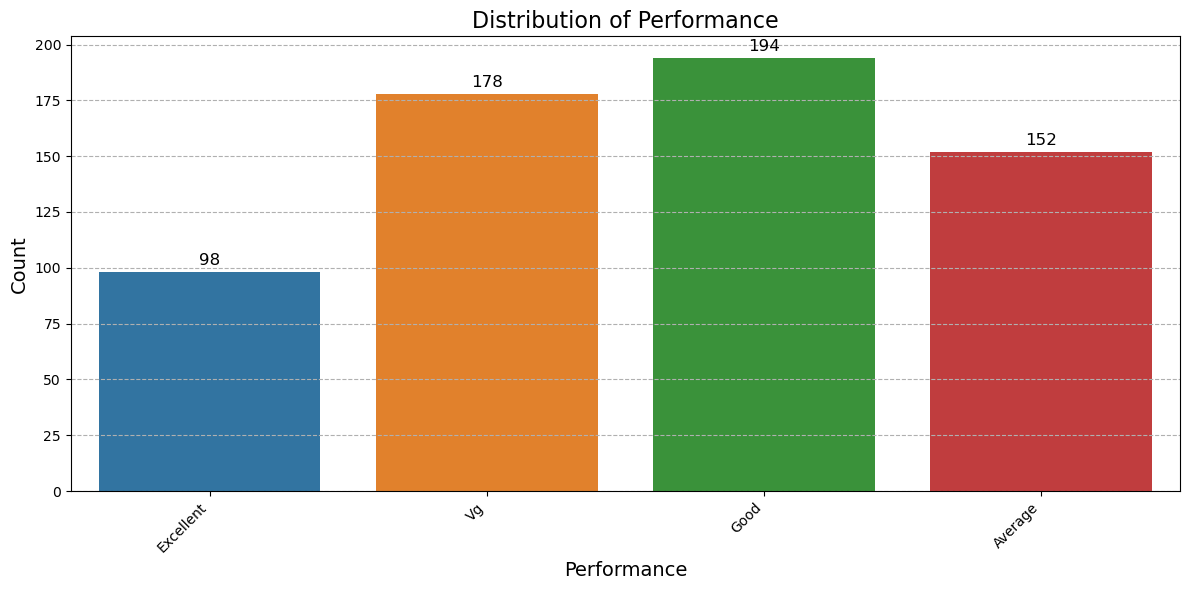

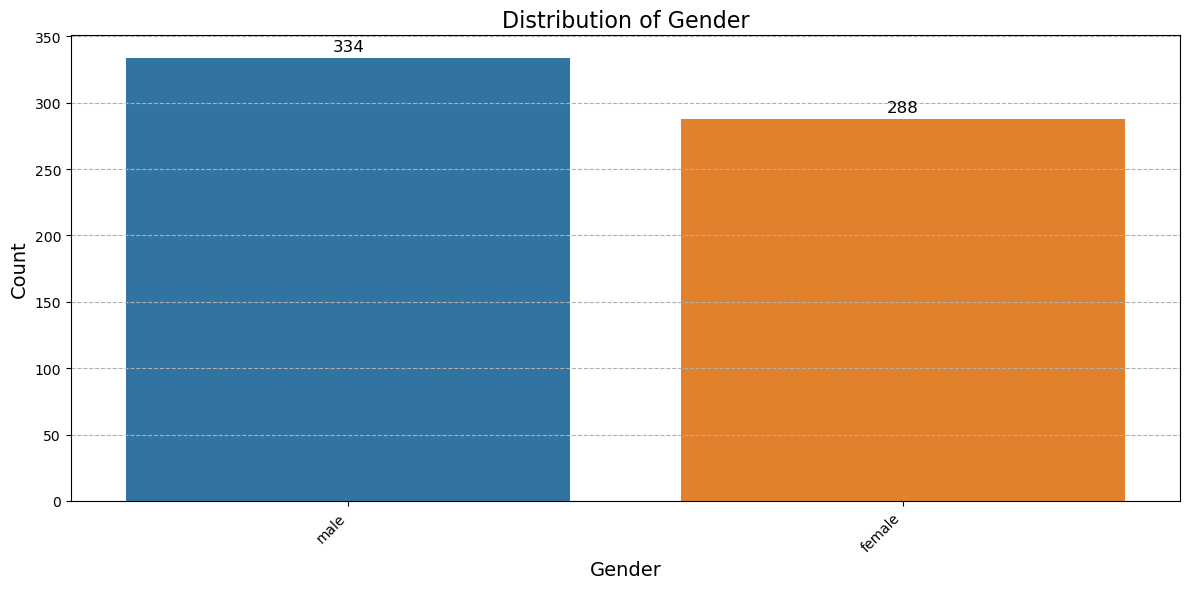

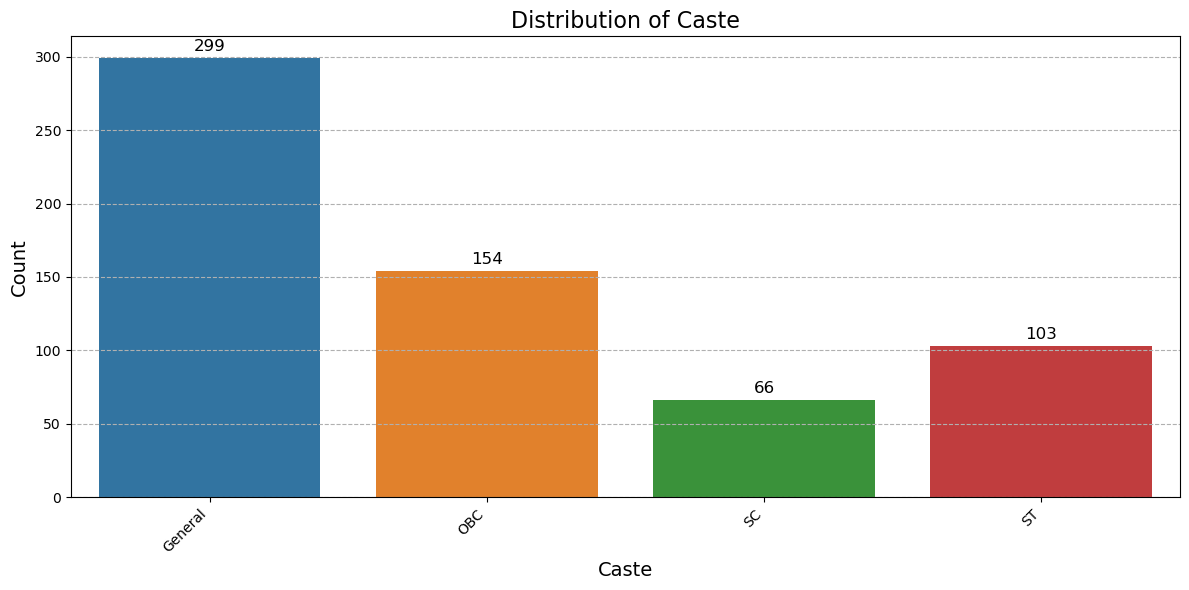

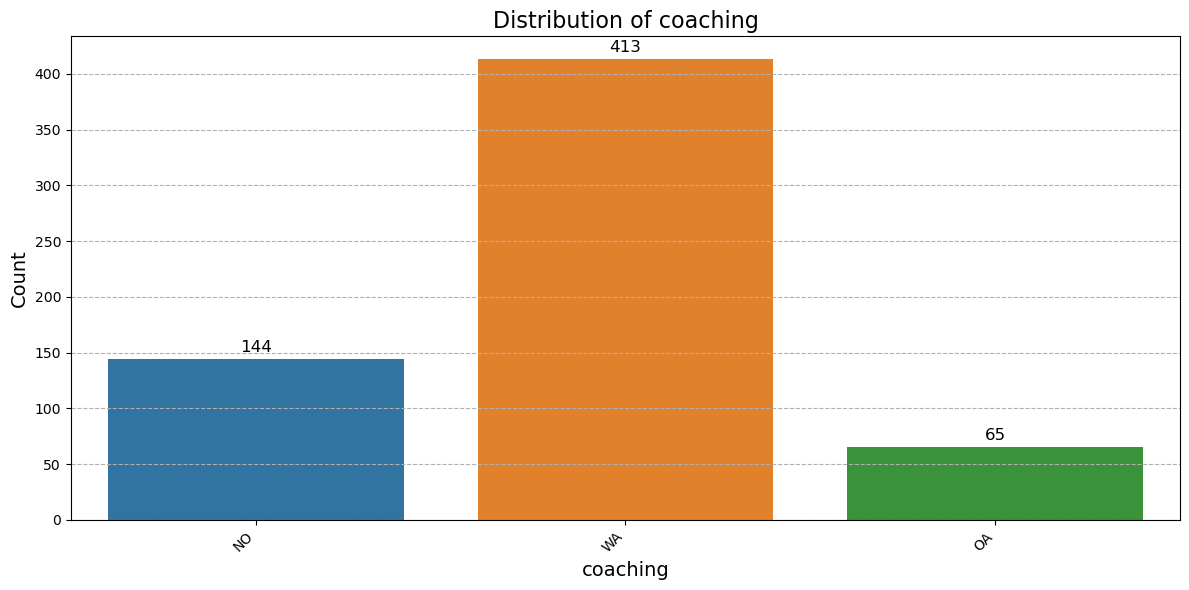

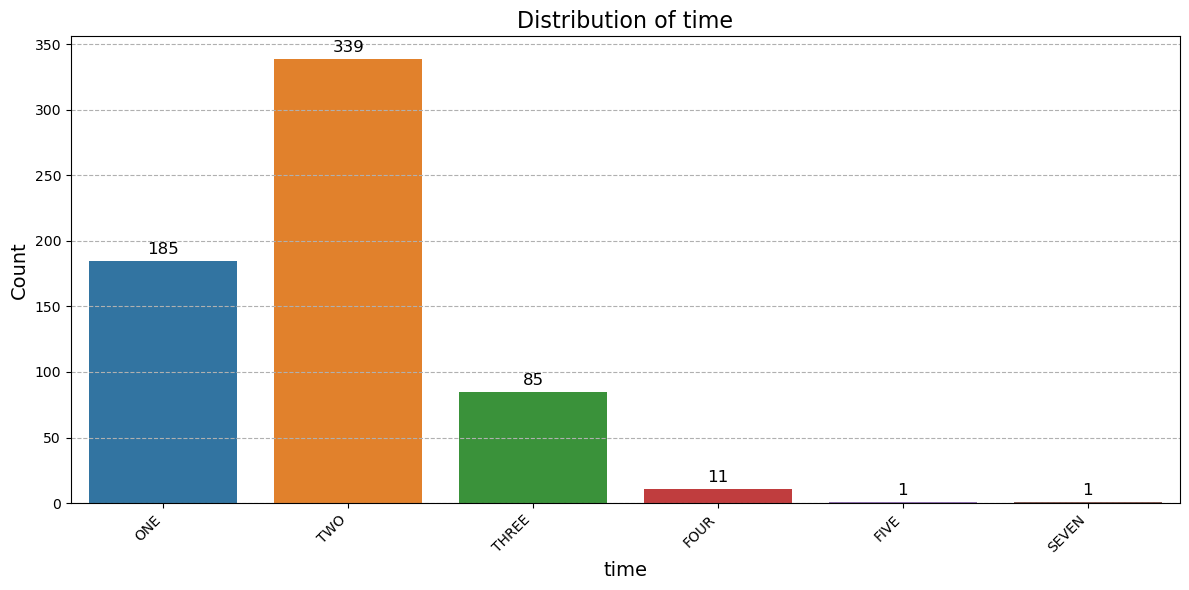

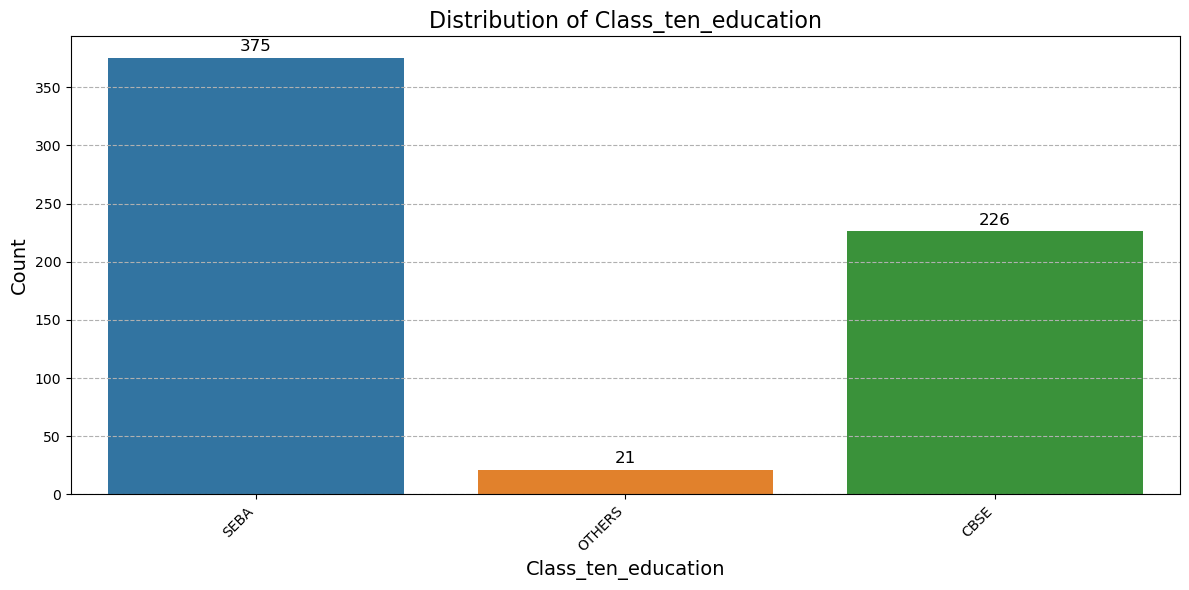

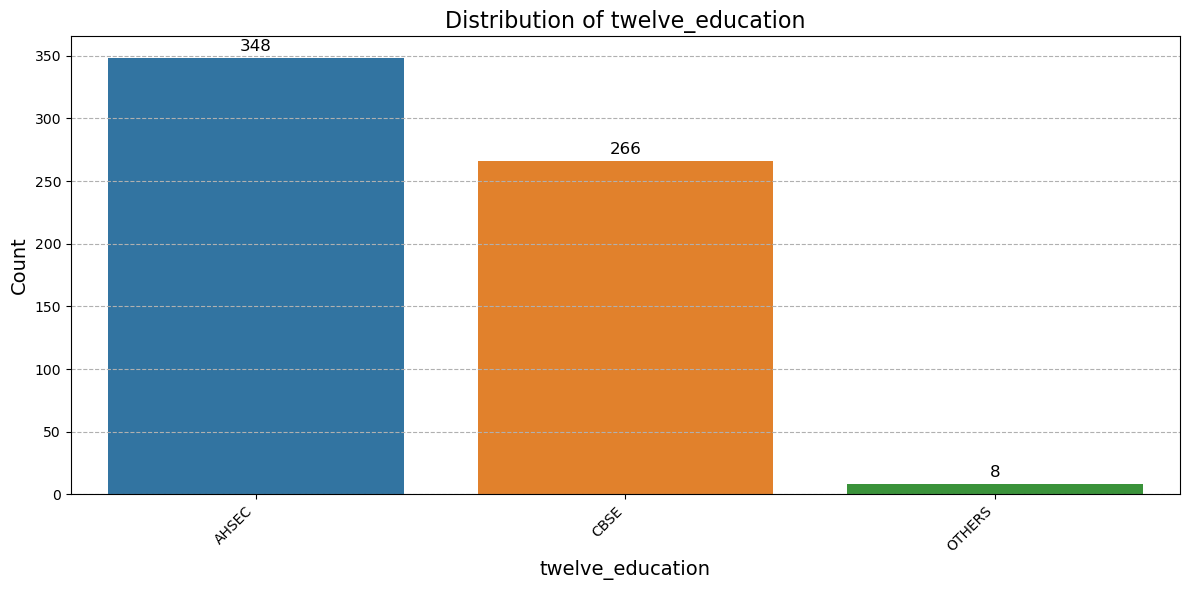

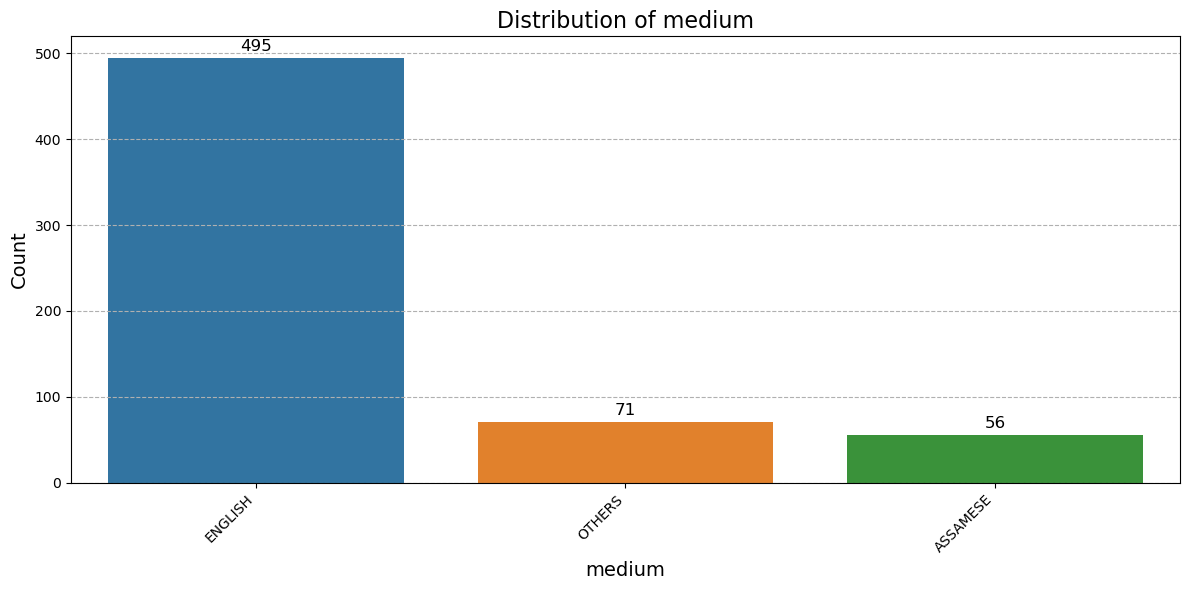

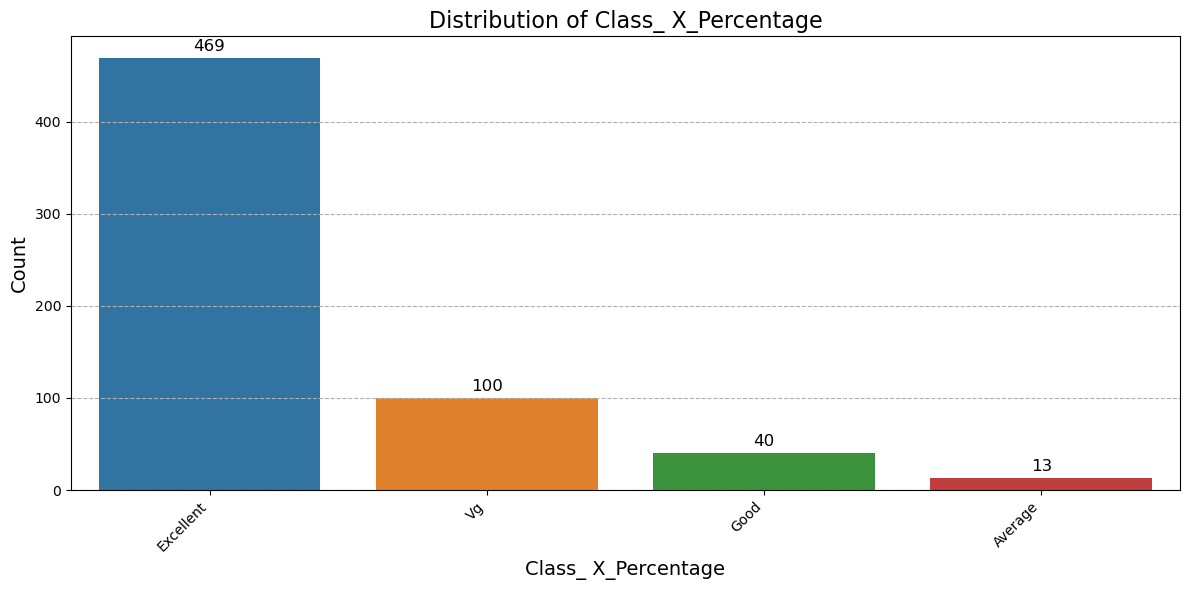

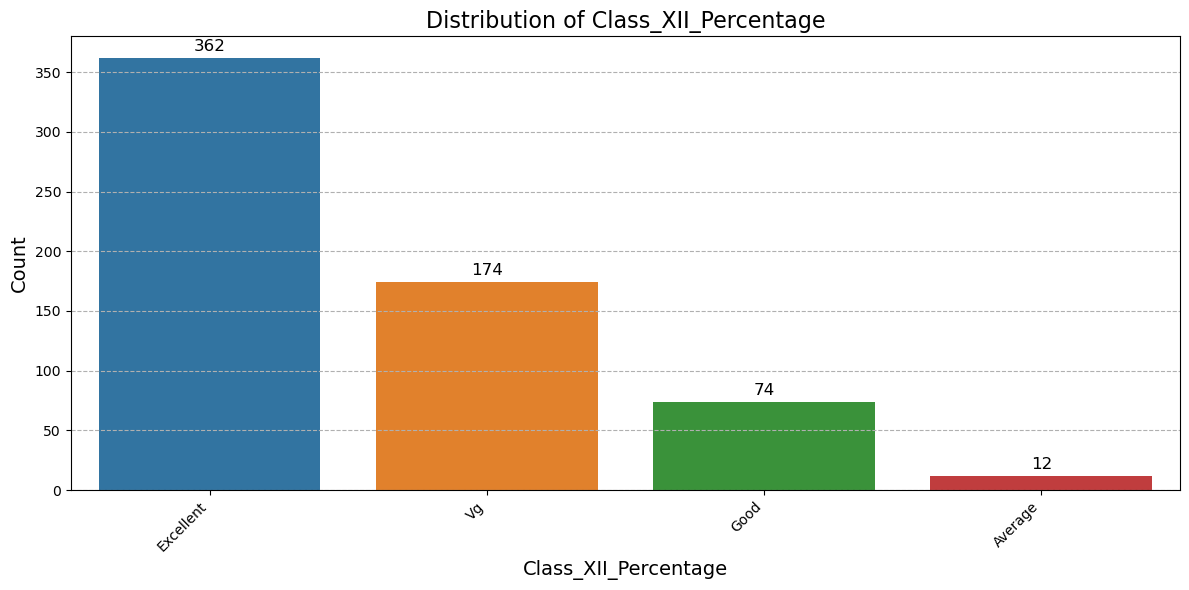

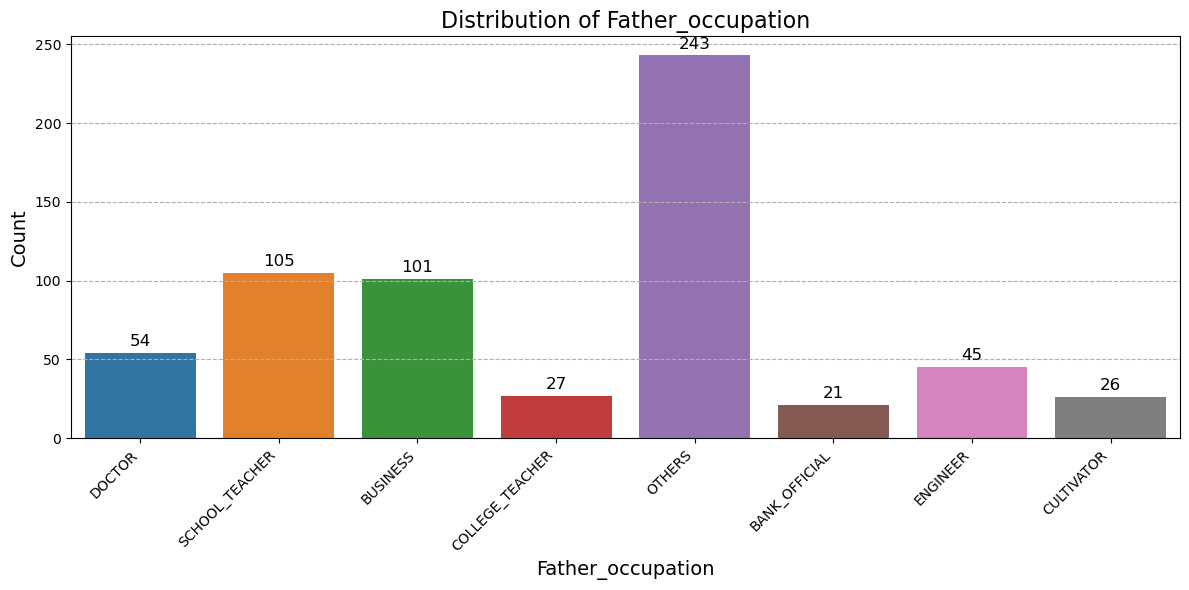

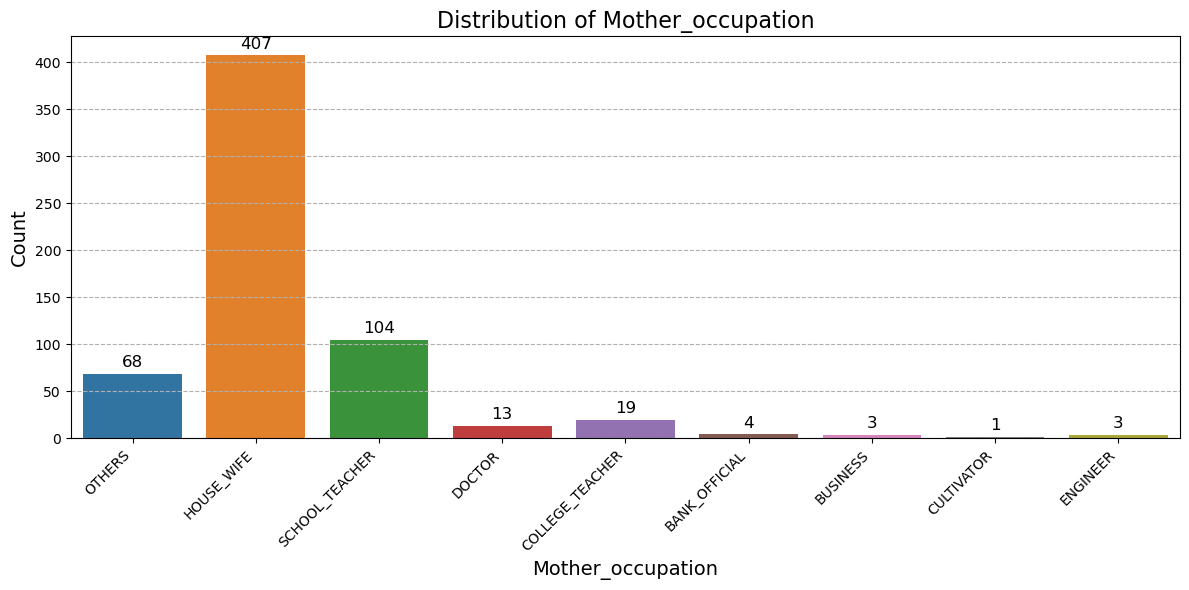

Before SMOTE:
Performance
2    157
3    137
0    126
1     77
Name: count, dtype: int64
After SMOTE:
Performance
3    157
2    157
0    157
1    157
Name: count, dtype: int64
Evaluating Multiple Classifiers:
Random Forest Accuracy: 0.4800
Gradient Boosting Accuracy: 0.4720
SVC Accuracy: 0.4640
Logistic Regression Accuracy: 0.4560
Evaluating Voting Classifier:
Voting Classifier Accuracy: 0.4800
Running Grid Search for Random Forest and Gradient Boosting:
Fitting 5 folds for each of 504 candidates, totalling 2520 fits
Best Parameters: {'classifier': RandomForestClassifier(), 'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 50}
Best Accuracy: 0.5207873015873016
Evaluating Stacking Classifier:
Stacking Classifier Accuracy: 0.4560
Comparing Classifiers with Cross-Validation:
Random Forest Accuracy: 0.4889 (+/- 0.0194)
Gradient Boosting Accuracy: 0.5048 (+/- 0.0299)
SVC Accurac

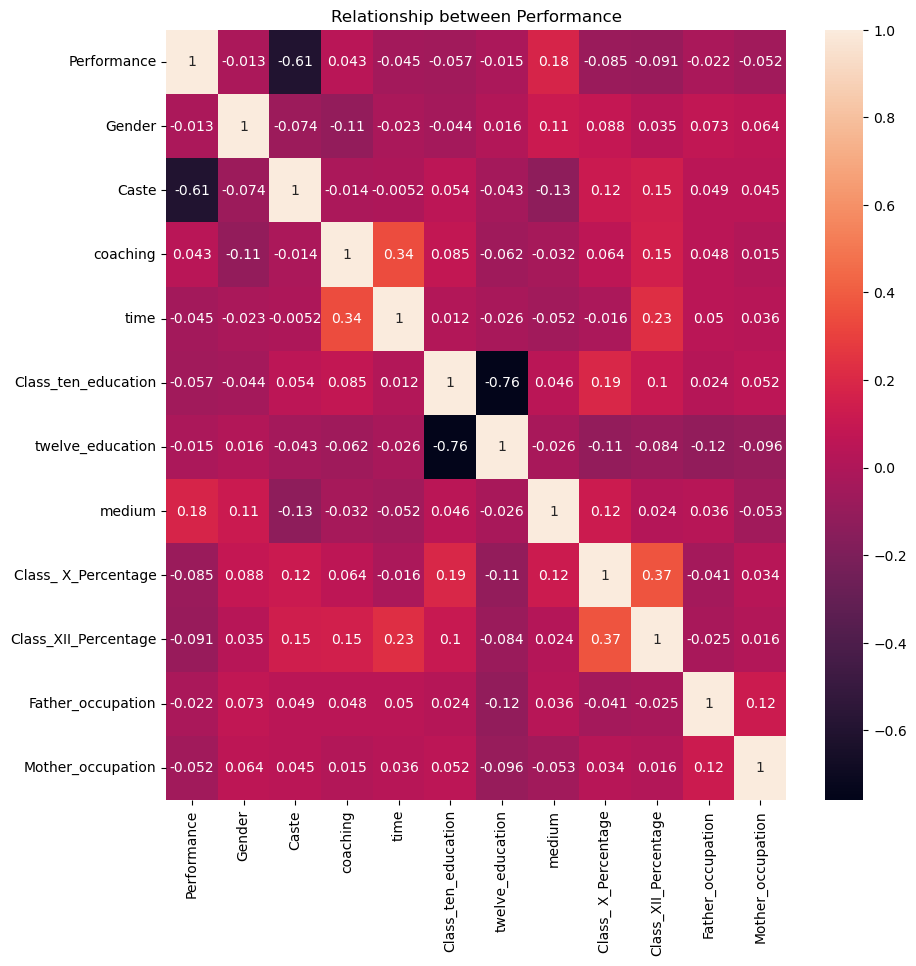

In [13]:
script_directory = os.getcwd()
parent_directory = os.path.dirname(script_directory)
datasets_directory = os.path.join(parent_directory, 'dataset')
filepath = os.path.join(datasets_directory, 'CEE_DATA.arff')

run_pipeline(filepath)